In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Loading Image Data

In [2]:
#Loading Image Data
BATCH_SIZE = 1 # set a btch size

print("\nLoading training data...")
#1) Create training_data_generator, an ImageDataGenerator that normalize, rotate, set zoom range, etc.
training_data_generator = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1)

#2) Use training_data_generator.flow_from_directory(...) to load the training data from the 'data/train' folder:
training_iterator = training_data_generator.flow_from_directory('data/train', class_mode='categorical',
                    color_mode='grayscale', target_size=(256,256), batch_size=BATCH_SIZE)




Loading training data...
Found 251 images belonging to 3 classes.


In [3]:
print("\nLoading validation data...")

#3) Create validation_data_generator, an ImageDataGenerator that just performs pixel normalization:

validation_data_generator = ImageDataGenerator(rescale=1./255)

#4) Use validation_data_generator.flow_from_directory(...) to load the validation data from the 'data/test' folder:

validation_iterator = validation_data_generator.flow_from_directory('data/test',class_mode='categorical',
                    color_mode='grayscale', target_size=(256,256), batch_size=BATCH_SIZE)



Loading validation data...
Found 66 images belonging to 3 classes.


# CNN model

In [4]:
#initilize galaxy sequential model
model = tf.keras.Sequential(name='Covid_19_Pneumonia_Classification')

#add an input layer
model.add(tf.keras.Input(shape=(256,256,1)))

model.add(tf.keras.layers.Conv2D(2,5,strides=3,padding="valid",activation="relu"))

#Add first max pooling layer 
model.add(tf.keras.layers.MaxPooling2D(pool_size=(5, 5), strides=(5,5)))

model.add(tf.keras.layers.Conv2D(4,3,strides=1,padding="valid",activation="relu"))

#Add second max pooling layer 
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))


model.add(tf.keras.layers.Flatten())

#add a Dense output layer
model.add(tf.keras.layers.Dense(3, activation="softmax"))


# Training and Compiling the Model

In [5]:
print("\nCompiling model...")

#3) Compile the model with an Adam optimizer, Categorical Cross Entropy Loss, and Accuracy and AUC metrics:

model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
   loss=tf.keras.losses.CategoricalCrossentropy(),
   metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()]
)


Compiling model...


In [6]:
print("\nTraining model...")

# epochs and early stopping
stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40) 
#4) Use model.fit(...) to train and validate our model for 5 epochs:

history = model.fit(
       training_iterator,
       steps_per_epoch=training_iterator.samples/BATCH_SIZE,
       epochs=15,
       validation_data=validation_iterator,
       validation_steps=validation_iterator.samples/BATCH_SIZE,
       callbacks=[stop])

#Print model information:
print(model.summary()) 

#classification report and confusion matrix
test_steps_per_epoch = np.math.ceil(validation_iterator.samples / validation_iterator.batch_size)

predictions = model.predict(validation_iterator, steps=test_steps_per_epoch)

test_steps_per_epoch = np.math.ceil(validation_iterator.samples / validation_iterator.batch_size)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = validation_iterator.classes
class_labels = list(validation_iterator.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   
 
cm=confusion_matrix(true_classes,predicted_classes)
print(cm)


Training model...
Epoch 1/15
251/251 [==============================] - 7s 26ms/step - loss: 1.1004 - categorical_accuracy: 0.2965 - auc: 0.4859 - val_loss: 1.0962 - val_categorical_accuracy: 0.4242 - val_auc: 0.5401
Epoch 2/15
251/251 [==============================] - 5s 21ms/step - loss: 1.0917 - categorical_accuracy: 0.4877 - auc: 0.5988 - val_loss: 1.0935 - val_categorical_accuracy: 0.4394 - val_auc: 0.5487
Epoch 3/15
251/251 [==============================] - 7s 29ms/step - loss: 1.0875 - categorical_accuracy: 0.4705 - auc: 0.6082 - val_loss: 1.0961 - val_categorical_accuracy: 0.4848 - val_auc: 0.5581
Epoch 4/15
251/251 [==============================] - 7s 26ms/step - loss: 1.0698 - categorical_accuracy: 0.6053 - auc: 0.6689 - val_loss: 1.0497 - val_categorical_accuracy: 0.5758 - val_auc: 0.6681
Epoch 5/15
251/251 [==============================] - 6s 25ms/step - loss: 1.0178 - categorical_accuracy: 0.5807 - auc: 0.7234 - val_loss: 0.8520 - val_categorical_accuracy: 0.6667 - va

# Model Accuracy

In [9]:
print('accuracy of the model is: ',model.evaluate(validation_iterator)[1]*100, '%')

66/66 [==============================] - 1s 7ms/step - loss: 0.3628 - categorical_accuracy: 0.8485 - auc: 0.9751
accuracy of the model is:  84.84848737716675 %


# Performance Plots

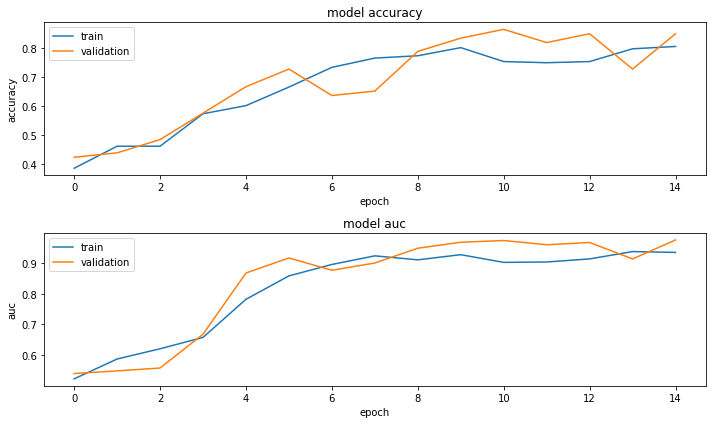

In [10]:
# plotting categorical and validation accuracy over epochs
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='upper left')
 
# plotting auc and validation auc over epochs
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history.history['auc'])
ax2.plot(history.history['val_auc'])
ax2.set_title('model auc')
ax2.set_xlabel('epoch')
ax2.set_ylabel('auc')
ax2.legend(['train', 'validation'], loc='upper left')
 
# used to keep plots from overlapping
fig.tight_layout()
plt.show()

# use this savefig call at the end of your graph instead of using plt.show()
fig.savefig('my_plots.png')